<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Projet Fil Rouge CO2</h1></center>
<center><h2>Preprocessing</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

Anthony et Isabelle - mentor Maxime

Le but de ce projet est d'identifier les caractéristiques techniques des véhicules qui jouent un rôle dans l'émission de CO2 à partir d'une base de données produite par l'Agence européenne de l'environnement qui contient la liste des voitures particulières enregistrés en France pour l'année 2019.

Ce document centralise les scripts du preprocessing commun aux deux approches, les étapes de préparation de données pour les modèles sont quant à elles rattachées aux scripts de modélisation.



> La structure du notebook est la suivante : 
>> I - [Préparation du dataset](#preparation)
>> 
>> Création du dataset “cars” (=> véhicules neufs acquis par au moins une personne en France en 2019) à partir du jeu de données source en supprimant les doublons sur un identifiant véhicule.
>>
>> II - [Supression de véhicules](#vehicules)
>>
>>
>>  - véhicules sans mesure d’émissions de CO2 pour le protocole WLTP
>>  - véhicules dont la variable Mh est codée “out of scope” et “duplicated”
>>  - véhicules dont le carburant est dans la liste suivante : électricité, hydrogène, super-éthanol, gaz de pétrole liquéfié, au gaz naturel, mélange gaz-naturel et biométhane
>>
>> III - [Supression et recodage des variables](#items)
>>
>> - supression : consommation de fuel et autonomie des véhicules électriques, numéro d'homologation, identifiant de la famille d’interpolation, contrôles de simulation CO2MPAS, consommation d’énergie électrique, réduction des émissions de CO2 en lien avec une éco-innovation (variables qui concernent peu de véhicules)
>> - recodage : éco-innovations, type de carburant, mode de carburation, mesures de largeur de voie, constructeur
>>
>> III - [Gestion des données manquantes](#NAN)
>> - recodage du mode de carburation et de la puissance par les valeurs vraies
>> - recodage des masses tests à partir d'une régression linéaire




# Import des librairies

In [22]:
# import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

path=r'C:/Users/ievrard/Documents/DataScientest/Data/Projet/'

## <a name="preparation"></a> Préparation du dataset

Spécification d'un véhicule : ensemble des entités référencées par un identifiant type-variant-version unique (TVV) et appartenant à une même famille d’interpolation de véhicule.

In [23]:
# lecture du fichier de véhicules immatriculés en France en 2019 (données extraite du site de l'AEE)
parc = pd.read_csv(path+'data_FR2019.csv', index_col=0, dtype={'Cn': 'str', 'IT': 'str'})

# supression des variables non renseignées en 2019
parc = parc.drop(columns=['Date of registration', 'Fuel consumption ', 'Electric range (km)'])

# Vérification des critères de requête
print("Modalité de la variable 'year' :", parc['year'].unique())
print("Modalité de la variable 'Status' :", parc['Status'].unique())
print("Modalité de la variable 'Country' :", parc['Country'].unique())
# supression des critères de requête
parc = parc.drop(columns=['year', 'Country', 'Status'])

# Taille du fichier
print("Taille du fichier:", f"{parc.shape[0]:,}".replace(',', ' '), "nouveaux véhicules immatriculés en France en 2019.")

Modalité de la variable 'year' : [2019]
Modalité de la variable 'Status' : ['F']
Modalité de la variable 'Country' : ['FR']
Taille du fichier: 2 305 720 nouveaux véhicules immatriculés en France en 2019.


In [24]:
# Création du fichier cars par élimination des doublons
parc.sort_values(by=['T','Va','Ve','VFN'], ascending=False)
cars = parc.drop_duplicates(subset=['T','Va','Ve','VFN'], keep = 'first', ignore_index=True)

# décompte du nombre de véhicules (size)
count = parc.groupby(['T','Va','Ve','VFN'],as_index=False, dropna=False,).size()
cars = cars.merge(count, on=['T','Va','Ve','VFN'], how='inner')

# Taille du fichier
print("Taille du fichier:", f"{cars.shape[0]:,}".replace(',', ' '), "véhicules uniques")

Taille du fichier: 16 975 véhicules uniques


In [25]:
# renommer les variables en otant les unité de mesure
dict_rename  = {'m (kg)': 'm',
                'Enedc (g/km)': 'Enedc',
                'Ewltp (g/km)':'Ewltp',
                'W (mm)':'W',
                'At1 (mm)':'At1',
                'At2 (mm)':'At2',
                'ec (cm3)':'ec',
                'ep (KW)':'ep',
                'Erwltp (g/km)':'Erwltp',
                'Ernedc (g/km)':'Ernedc',
                'z (Wh/km)':'z'
               }
cars = cars.rename(dict_rename,axis=1)

### <a name="vehicules"></a> Supression de véhicules


In [26]:
# décompte des lignes supprimées
crit_Mh = len(cars[cars['Mh'].map(lambda x: x=='OUT OF SCOPE' or x=='DUPLICATE')])
crit_WLTP = cars['Ewltp'].isna().sum()
crit_Ft = len(cars[cars['Ft'].map(lambda x: x in('electric', 'hydrogen', 'e85','lpg','ng','ng-biomethane'))])
total = crit_Mh+crit_WLTP+crit_Ft
print(total, 'véhicules supprimés dont :')
print (' - véhicules dupliqués ou hors champ:', crit_Mh)
print (' - véhicules hors protocole WLTP:', crit_WLTP)
print (' - véhicules mode de caburation trop peu fréquent ou sans émission:', crit_Ft)



3442 véhicules supprimés dont :
 - véhicules dupliqués ou hors champ: 82
 - véhicules hors protocole WLTP: 3147
 - véhicules mode de caburation trop peu fréquent ou sans émission: 213


In [27]:
## suppression des véhicules
cars.drop(cars[
    (cars['Ft'].isin(['electric','hydrogen','e85','lpg','ng','ng-biomethane'])) | 
    (cars['Ewltp'].isna()) | 
    (cars['Mh'].isin(['DUPLICATE','hydrogen']))
].index, inplace = True )

# display(cars.shape)
print("Nombre de véhicules final = ", cars.shape[0])

Nombre de véhicules final =  13571


### <a name="items"></a> Supression et recodage de variables


In [28]:
# Supression
list_var = ['Mk','Man','MMS','Tan','VFN','Erwltp','Ernedc','z', 'Vf', 'De']
cars = cars.drop(list_var, axis=1)

In [29]:
# recodage éco-innovation en binaire
cars['IT'] = (cars['IT'].notnull()).astype('int')

# recodage constructeur hors pool
cars['Mp'] = cars['Mp'].fillna('NON CONCERNE')

# création de la variable AT1<AT2
cars['At2supAt1'] = np.where(cars.At1<cars.At2, 1, 0)
print('\nvéhicules At1<At2')
display(cars.At2supAt1.value_counts(normalize=True))

# recodage des véhicules hybrides rechargeables
cars['Ft'].replace(to_replace=['diesel/electric','petrol/electric'], value=['diesel','petrol'], inplace=True)

# recodage varibale Fm
cars['Fm'].replace(to_replace=['M','P','H'], value=['mono_fuel','OVC-HEV','NOVC-HEV'], inplace = True)

# codage constructeurs
cars['Mp'].replace(to_replace=['NON CONCERNE','HONDA MOTOR EUROPE LTD'], value='OTHER', inplace=True)
cars['Mp'].replace(to_replace=['RENAULT','MITSUBISHI MOTORS'], value='RNM POOL', inplace=True)
cars['Mp'].replace(to_replace=['TATA MOTORS JAGUAR LAND ROVER'], value='JLR', inplace=True)
cars['Mp'].replace(to_replace=['VW GROUP PC'], value='VW GROUP', inplace=True)
cars['Mp'].replace(to_replace=['FORD-WERKE GMBH'], value='FORD-WERKE', inplace=True)

cars.loc[(cars['Mh'] == 'NISSAN'), 'Mp'] = 'RNM POOL'
cars.Mp.value_counts()



véhicules At1<At2


0    0.863533
1    0.136467
Name: At2supAt1, dtype: float64

### <a name="NAN"></a> Gestion des données manquantes


In [30]:
# Données manquantes (%)
df1 = pd.DataFrame(cars.isna().sum()).rename(columns = {0:'missing (n)'})
df2 = pd.DataFrame(cars.isna().mean(axis = 0)*100).round(2).rename(columns = {0:'missing (%)'})

NAN = pd.concat([df1, df2], axis=1).sort_values(by = ['missing (n)'], ascending=False)
display(NAN[NAN['missing (n)']!=0])

,missing (n),missing (%)
Mt,697,5.14
Fm,8,0.06
ep,2,0.01


 - Les données manquantes sont des "non concernés" pour l'item IT.
 - les véhicules dont le mode de carburation ou la puissance est inconnue peuvent être recodés grâce à leur nom commercial (recherche des informations sur les sites des constructeurs

In [31]:
# information sur les 8 véhicules sans mode de carburation
display(cars[['Mh','Cn','Fm','Ft']][cars['Fm'].isna()==True])
# information sur les 2 véhicules dont la puissance est inconnue
display(cars[['Mh','Cn','ep']][cars['ep'].isna()==True])

,Mh,Cn,Fm,Ft
8958,BMW AG,520d,NaN,unknown
8959,BMW AG,520d,NaN,unknown
8960,BMW AG,520d,NaN,unknown
8961,BMW AG,520d,NaN,unknown
9051,BMW AG,520d xDrive,NaN,unknown
9052,BMW AG,520d xDrive,NaN,unknown
9053,BMW AG,520d xDrive,NaN,unknown
9054,BMW AG,520d xDrive,NaN,unknown


,Mh,Cn,ep
9984,BMW AG,i3 94 REX,NaN
9987,BMW AG,i3s 94 REX,NaN


In [32]:
# recodage des données manquantes : valeurs vraies
cars['ep'] = cars['ep'].fillna(170)

list = cars[cars['Fm'].isna()==True].index
cars.loc[list, 'Ft'] = 'diesel'
cars.loc[list, 'Fm'] = 'mono_fuel'


,resultat_test
pearson_coeff,0.984427
p-value,0.000000


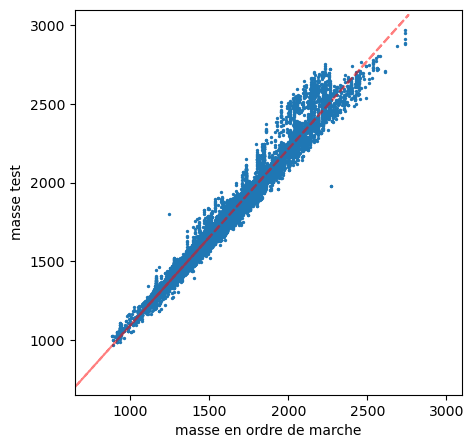

In [33]:
# recodage des données manquantes pour la masse avec une regression linéaire

# séparation si données manquantes pour Mt
cars_reg = cars[cars['Mt'].notna()]
cars_imp = cars[cars['Mt'].isna()]

# régression Mt = a + bm
reg = LinearRegression()
reg.fit(cars_reg[['m']],cars_reg['Mt'])
slope = reg.coef_
inter = reg.intercept_

# corrélation entre les 2 différentes mesures de masse
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(cars['m'],cars['Mt'], s=2)
ax.set_xlim([cars['m'].min(),3100])
ax.set_ylim([cars['m'].min(),3100])

ax.set_xlabel('masse en ordre de marche')
ax.set_ylabel('masse test')

plt.plot(cars['m'], inter + slope*cars['m'], '--r', alpha=0.5);

pd.DataFrame(pearsonr(cars_reg['m'], cars_reg['Mt']), index=['pearson_coeff','p-value'], columns=['resultat_test'])


In [34]:
# prédiction 
pred = pd.DataFrame(reg.predict(cars[['m']]).round(1), index=cars.index, columns=['pred_Mt'])
cars['indicator'] = cars.Mt.isnull()

# remplacement des données manquantes par la prédiction
cars.Mt.fillna(pred.pred_Mt, inplace=True)


In [36]:
# export des données après nettoyage
cars.reset_index(inplace=True, drop=True)
cars.to_csv(path+'cars_FR2019_clean.csv')
cars.to_excel(path+'cars_FR2019_clean.xlsx', sheet_name='véhicules', index=False)